# NLP - Named Entity Recognition(NER)

NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. 

Generative VS Discriminative Models

Let's say you have input data x and you want to classify the data into labels y. 
A generative model learns the joint probability distribution p(x,y) and a discriminative model learns the conditional 
probability distribution p(y|x) - which you should read as "the probability of y given x".

Generative classifiers
- Naïve Bayes
- Bayesian networks
- Markov random fields
- Hidden Markov Models (HMM)

Discriminative Classifiers
- Logistic regression
- Scalar Vector Machine
- Traditional neural networks
- Nearest neighbour
- Conditional Random Fields (CRF)s

In [ ]:
Conditional Random Field(CRF)

The sentence “He reckons the current account deficit will narrow to only # 1.8 billion in September.” 
can be divided as follows:

[NP He ] [VP reckons ] [NP the current account deficit ] [VP will narrow ] [PP to ] [NP only # 1.8 billion ] [PP in ] 
[NP September ] .

In this example, NP stands for a noun phrase, VP for a verb phrase, and PP for a prepositional phrase. This task is 
formalized as a sequential labeling task in which a sequence of tokens in a text is assigned with a sequence of labels.

In [ ]:
The target ‘tag’ follows the Inside-outside-beginning (IOB) tagging format. The IOB format (short for inside, outside, 
beginning) is a common tagging format for tagging tokens in named entity recognition. The target ‘tag’ has three kinds of tags.

B-indications : Beginning tag indicates that the token is the beginning of a disease entity (disease name in this case).
I-indications : Inside tag indicates that the token is inside an entity.
O : Outside tag indicates that a token is outside a disease entity.

In [ ]:
Therefore, any word which does not represent the disease name has to be classified as “O” tag. Similarly, the first word 
of disease name has to be classified as “B-Indication” and following words of disease name as “I-Indication”.

In [ ]:
B-NP He
B-VP reckons
B-NP the
I-NP current
I-NP account
I-NP deficit
B-VP will
I-VP narrow
B-PP to
B-NP only
I-NP #
I-NP 1.8
I-NP billion
B-PP in
B-NP September
O    .

In [ ]:
Feature (attribute) generation
The next step is to preprocess the training and testing data to extract attributes that express the characteristics 
of words (items) in the data. CRFsuite internally generates features from attributes in a data set. In general, this is 
the most important process for machine-learning approaches because a feature design greatly affects the labeling accuracy.
Here, we extract 19 kinds of attributes from a word at position t (in offsets from the begining of a sequence):

- w[t-2], w[t-1], w[t], w[t+1], w[t+2],
- w[t-1]|w[t], w[t]|w[t+1],
- pos[t-2], pos[t-1], pos[t], pos[t+1], pos[t+2],
- pos[t-2]|pos[t-1], pos[t-1]|pos[t], pos[t]|pos[t+1], pos[t+1]|pos[t+2],
- pos[t-2]|pos[t-1]|pos[t], pos[t-1]|pos[t]|pos[t+1], pos[t]|pos[t+1]|pos[t+2]
- In this list, w[t] and pos[t] present the word and part-of-speech respectively at position t in a sequence. 
These features express the characteristic of the word at position t by using information from surrounding words, 
e.g., w[t-1] and pos[t+1]. For example, the token 'the' in the following example,

In [ ]:
        He PRP B-NP
        reckons VBZ B-VP
  t --> the DT B-NP
        current JJ I-NP
        account NN I-NP

In [ ]:
obtains these attributes (position t is omitted for simplicity),

- w[-2]=He, w[-1]=reckons, w[0]=the, w[1]=current, w[2]=account
- w[-1]|w[0]=reckons|the, w[0]|w[1]=the|current
- pos[-2]=PRP, pos[-1]=VBZ, pos[0]=DT, pos[1]=JJ, pos[2]=NN
- pos[-2]|pos[-1]=PRP|VBZ, pos[-1]|pos[0]=VBZ|DT, pos[0]|pos[1]=DT|JJ, pos[1]|pos[2]=JJ|NN
- pos[-2]|pos[-1]|pos[0]=PRP|VBZ|DT, pos[-1]|pos[0]|pos[1]=VBZ|DT|JJ, pos[0]|pos[1]|pos[2]=DT|JJ|NN

In [ ]:
In this example, the attribute "w[0]=the" presents the event where the current token is "the", and 
the attribute "pos[0]|pos[1]|pos[2]=DT|JJ|NN" presents the event where the parts-of-speech at the current, 
next, and two words ahead are DT, JJ, NN, respectively. CRFsuite will learn associations between these attributes 
(e.g, "pos[0]|pos[1]|pos[2]=DT|JJ|NN") and labels (e.g., "B-NP") to predict a label sequence for a given text. Please 
note that an attribute need not follow the convention "name=value", e.g., "w[0]=the". CRFsuite accepts any string as an 
attribute name as long as the string does not contain a colon character (that is used to separate an attribute name and 
its weight). The convention "name=value" is merely for the convenience to interpret attribute names.

In [3]:
#import packages
import pandas as pd
import re
import csv
import pandas as pd
import nltk
import numpy as np
import string
from nltk import word_tokenize, pos_tag, pos_tag_sents,sent_tokenize
from nltk import RegexpParser
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import string
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report

In [4]:
#Reading the csv file
df = pd.read_csv('C:/Users/kiruthika.parthiban/Desktop/EHR/Notes.csv', encoding = "ISO-8859-1")

In [5]:
#Display first 10 rows
df.head(10)

,Paragraph#,Notes
0,para1,The patient is a 32-year-old man\nwith a hist...
1,para2,35 yo M w/ hx muscular distrophy w/ chronic re...
2,para3,Mr. [**Known lastname 36733**] was transferre...
3,para4,The patient is a 74 year old\nmale with a his...
4,para5,\n This is a 49-year-old gentleman\nwith a kno...
5,para6,"The patient is a 78-year-old,\nCantonese spea..."
6,para7,Mr. [**Known lastname 14218**] is a 45-year-o...
7,para8,The patient's presenting illness\nwas subster...
8,para9,The patient's presenting illness\nwas subster...
9,para10,This is a 60 year old male with\na history of...


In [6]:
df.describe()

,Paragraph#,Notes
count,100,100
unique,100,99
top,para9,The patient is a 20 year old\ngentleman with ...
freq,1,2


In [7]:
#Checking null values, if any.
df.isnull().sum()

Paragraph#    0
Notes         0
dtype: int64

In [8]:
paragraph = []
for val in df['Notes']:
    paragraph.append(nltk.sent_tokenize(val))

In [9]:
# create senetence numbering
i=0
j=0
lines = []
para_no = []
sent_no = []
for para in paragraph:
    j+=1
    for sent in para:
        lines.append(sent)
        para_no.append(j)
        sent_no.append(i)
        i+=1

# create a dataframe
data = { 'para_no': para_no, 'sent_no': sent_no, 'lines': lines}
df = pd.DataFrame(data)

In [10]:
df.head(10)

,para_no,sent_no,lines
0,1,0,The patient is a 32-year-old man\nwith a hist...
1,1,1,Plan was for him to eventually\ngo home to be ...
2,1,2,The patient is\ndependent for all his ADLs.
3,2,3,35 yo M w/ hx muscular distrophy w/ chronic re...
4,2,4,Patient first had a trach placed in [**11-30**...
5,2,5,He subsequently had trach replacement on [**21...
6,2,6,In [**9-2**] pt was treated w/ 10d\ncourse of ...
7,2,7,"At home yesterday, patient's cuff blew out and..."
8,2,8,Subsequent replacement w/ his back-up trach wo...
9,2,9,Pt was brought to [**Hospital3 417**] MC.


In [11]:
df['lines'][0]

' The patient is a 32-year-old man\nwith a history of fascioscapulohumeral muscular dystrophy\nwith chronic respiratory failure on home bipap pressure\nsupport 18, PEEP 8 for the past 9 years (24 hours a day for\nthe past 2 years), admitted on [**2130-12-4**] for an elective\ntracheostomy placement because of worsening nasal breakdown\nfrom the bipap nasal pillows.'

In [12]:
# Remove punctuations found in the columns
df['lines'] = df["lines"].apply(lambda x:''.join([i for i in x
                                                  if i not in string.punctuation]))

In [13]:
df['lines'][0]

' The patient is a 32yearold man\nwith a history of fascioscapulohumeral muscular dystrophy\nwith chronic respiratory failure on home bipap pressure\nsupport 18 PEEP 8 for the past 9 years 24 hours a day for\nthe past 2 years admitted on 2130124 for an elective\ntracheostomy placement because of worsening nasal breakdown\nfrom the bipap nasal pillows'

In [14]:
# Remove stop words from the sentences
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
df['lines'] = df['lines'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['lines'][0]

'The patient 32yearold man history fascioscapulohumeral muscular dystrophy chronic respiratory failure home bipap pressure support 18 PEEP 8 past 9 years 24 hours day past 2 years admitted 2130124 elective tracheostomy placement worsening nasal breakdown bipap nasal pillows'

In [16]:
# importing all necessery modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

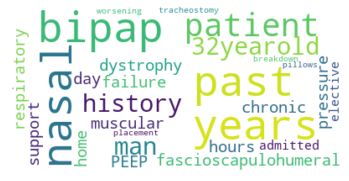

In [17]:
# for a single line summary
text = df['lines']
text = text[0]
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [18]:
text = " ".join(review for review in df['lines'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 96485 words in the combination of all review.


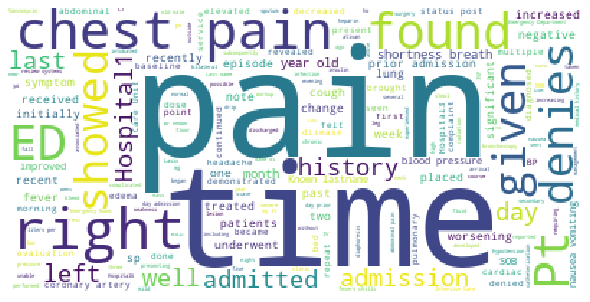

In [19]:
stopwords = set(STOPWORDS)
stopwords.update(["patient", "now", "started", "transferred", "noted","presented","family","reports","approximately","noted","home","Hospital"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [20]:
# convert dataframe into list
sentences = df['lines'].tolist()
tagged_texts = pos_tag_sents(map(word_tokenize, sentences))

i=0
lines = []
sent_no = []
pos_tag = []
for val in tagged_texts:
    i+=1
    for word, tag in val:
        lines.append(word)
        pos_tag.append(tag)
        sent_no.append('sentence'+str(i))

In [21]:
# create a dataframeO
data = { 'sent_no':sent_no,'words': lines, 'pos_tag':pos_tag}
ner_df = pd.DataFrame(data)

In [22]:
ner_df.head(10)
#ner_df.to_csv("C:/Users/kiruthika.parthiban/Desktop/EHR/Train_data.csv", index=False)

,sent_no,words,pos_tag
0,sentence1,The,DT
1,sentence1,patient,NN
2,sentence1,32yearold,CD
3,sentence1,man,NN
4,sentence1,history,NN
5,sentence1,fascioscapulohumeral,JJ
6,sentence1,muscular,JJ
7,sentence1,dystrophy,NN
8,sentence1,chronic,JJ
9,sentence1,respiratory,NN


In [84]:
symptom_name = pd.read_csv('C:/Users/kiruthika.parthiban/Desktop/EHR/symptom_name.csv', encoding = "ISO-8859-1")
drug_name = pd.read_csv('C:/Users/kiruthika.parthiban/Desktop/EHR/Drug_names.csv', encoding = "ISO-8859-1")
dosage_detail = pd.read_csv('C:/Users/kiruthika.parthiban/Desktop/EHR/Dosage_details.csv', encoding = "ISO-8859-1")
regimen_detail = pd.read_csv('C:/Users/kiruthika.parthiban/Desktop/EHR/Regimen.csv', encoding = "ISO-8859-1")

In [86]:
drug_name = drug_name.drop_duplicates(['Drug_names'])
dosage_detail = dosage_detail.drop_duplicates(['Dosage_details'])
regimen_detail = regimen_detail.drop_duplicates(['Regimens'])

In [87]:
drug_name['Drug_names'] = drug_name['Drug_names'].str.lower()
dosage_detail['Dosage_details'] = dosage_detail['Dosage_details'].str.lower()
regimen_detail['Regimens'] = regimen_detail['Regimens'].str.lower()

In [77]:
ner_df['label'] = ner_df['words'].str.lower().map(symptom_name.set_index('Symptom_Name')['Tag'])
ner_df['label'] = ner_df['words'].map(regimen_detail.set_index('Regimens')['Tag'])
ner_df['label'] = ner_df['words'].map(drug_name.set_index('Drug_names')['Tag'])
ner_df['label'] = ner_df['words'].map(doage_detail.set_index('Dosage_details')['Tag'])

In [23]:
ner_df = pd.read_csv("C:/Users/kiruthika.parthiban/Desktop/EHR/Train_data.csv",encoding = "ISO-8859-1")

In [24]:
ner_df['label'].unique()

array(['O', 'AGE', 'GEND', 'B-D', 'I-D', 'E-D', 'O-D', 'B-R', 'I-R',
       'E-R', 'B-S', 'I-S', 'O-S', 'E-S', 'B-AGE', 'O-AGE', 'O-R', 'S',
       'D', 'B-N', 'I-N', 'O-N', 'E-AGE', 'B-TIME', 'I-TIME', 'E-TIME',
       'O-TIME', 'I-AGE', 'M', 'R', 'E-N'], dtype=object)

In [25]:
ner_df.isnull().sum()

sent_no    0
words      0
pos_tag    0
label      0
dtype: int64

In [26]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['words'].values.tolist(),
                                                       s['pos_tag'].values.tolist(),
                                                       s['label'].values.tolist())]
        self.grouped = self.df.groupby("sent_no").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['sentence{}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [27]:
#Displaying one full sentence
getter = sentence(ner_df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'The patient 32yearold man history fascioscapulohumeral muscular dystrophy chronic respiratory failure home bipap pressure support 18 PEEP 8 past 9 years 24 hours day past 2 years admitted 2130124 elective tracheostomy placement worsening nasal breakdown bipap nasal pillows'

In [28]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('The', 'DT', 'O'), ('patient', 'NN', 'O'), ('32yearold', 'CD', 'AGE'), ('man', 'NN', 'GEND'), ('history', 'NN', 'O'), ('fascioscapulohumeral', 'JJ', 'B-D'), ('muscular', 'JJ', 'I-D'), ('dystrophy', 'NN', 'E-D'), ('chronic', 'JJ', 'B-D'), ('respiratory', 'NN', 'I-D'), ('failure', 'NN', 'O-D'), ('home', 'NN', 'O'), ('bipap', 'NN', 'B-R'), ('pressure', 'NN', 'I-R'), ('support', 'NN', 'E-R'), ('18', 'CD', 'O'), ('PEEP', 'NNP', 'O'), ('8', 'CD', 'O'), ('past', 'IN', 'O'), ('9', 'CD', 'O'), ('years', 'NNS', 'O'), ('24', 'CD', 'O'), ('hours', 'NNS', 'O'), ('day', 'NN', 'O'), ('past', 'IN', 'O'), ('2', 'CD', 'O'), ('years', 'NNS', 'O'), ('admitted', 'VBD', 'O'), ('2130124', 'CD', 'O'), ('elective', 'JJ', 'B-S'), ('tracheostomy', 'NN', 'I-S'), ('placement', 'NN', 'O-S'), ('worsening', 'VBG', 'E-S'), ('nasal', 'JJ', 'B-S'), ('breakdown', 'JJ', 'I-S'), ('bipap', 'NN', 'O-S'), ('nasal', 'NN', 'B-S'), ('pillows', 'NNS', 'E-S')]


In [29]:
sentences = getter.sentences

In [30]:
# Feature extraction
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [31]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [33]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [34]:
crf.classes_

['O',
 'M',
 'S',
 'AGE',
 'GEND',
 'B-D',
 'I-D',
 'O-D',
 'E-D',
 'O-AGE',
 'B-S',
 'E-S',
 'B-N',
 'E-N',
 'I-S',
 'O-S',
 'D',
 'B-TIME',
 'I-TIME',
 'E-TIME',
 'B-AGE',
 'I-AGE',
 'E-AGE',
 'B-R',
 'E-R',
 'I-N',
 'O-N',
 'I-R',
 'O-R',
 'O-TIME',
 'R']

In [35]:
#Predicting on the test set.
y_pred = crf.predict(X_test)

In [36]:
labels = list(crf.classes_)
labels.remove('O')
labels

['M',
 'S',
 'AGE',
 'GEND',
 'B-D',
 'I-D',
 'O-D',
 'E-D',
 'O-AGE',
 'B-S',
 'E-S',
 'B-N',
 'E-N',
 'I-S',
 'O-S',
 'D',
 'B-TIME',
 'I-TIME',
 'E-TIME',
 'B-AGE',
 'I-AGE',
 'E-AGE',
 'B-R',
 'E-R',
 'I-N',
 'O-N',
 'I-R',
 'O-R',
 'O-TIME',
 'R']

In [38]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

C:\Users\kiruthika.parthiban\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kiruthika.parthiban\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           D      1.000     0.250     0.400         4
           M      1.000     0.556     0.714         9
           R      0.000     0.000     0.000         0
           S      0.964     0.704     0.813       189
       B-AGE      0.000     0.000     0.000         1
       E-AGE      0.000     0.000     0.000         1
       I-AGE      0.000     0.000     0.000         1
       O-AGE      1.000     1.000     1.000         3
         B-D      0.700     0.875     0.778         8
         E-D      0.000     0.000     0.000         1
         I-D      0.667     0.800     0.727         5
         O-D      0.500     0.333     0.400         3
         B-N      0.750     0.429     0.545         7
         E-N      1.000     0.750     0.857         4
         I-N      0.000     0.000     0.000         2
         O-N      0.000     0.000     0.000         2
         B-R      0.000     0.000     0.000         0
         E-R      0.000    

In [37]:
f1_score = flat_f1_score(y_test, y_pred, average = 'weighted',labels=labels)
print(f1_score)

C:\Users\kiruthika.parthiban\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kiruthika.parthiban\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.753144599999869


In [42]:
import scipy.stats
import sklearn
from sklearn.metrics import make_scorer
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


#define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000267AF8A1688>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['M', 'S', 'AGE', 'GEND',

In [43]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.03404473265848538, 'c2': 0.001462031214198324}
best CV score: 0.7282807719286195
model size: 0.16M


In [45]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           D      1.000     0.500     0.667         4
           M      1.000     0.556     0.714         9
           R      0.000     0.000     0.000         0
           S      0.963     0.815     0.883       189
       B-AGE      0.000     0.000     0.000         1
       E-AGE      0.000     0.000     0.000         1
       I-AGE      0.000     0.000     0.000         1
       O-AGE      1.000     1.000     1.000         3
         B-D      0.700     0.875     0.778         8
         E-D      0.000     0.000     0.000         1
         I-D      0.571     0.800     0.667         5
         O-D      0.500     0.333     0.400         3
         B-N      0.833     0.714     0.769         7
         E-N      1.000     0.750     0.857         4
         I-N      0.000     0.000     0.000         2
         O-N      0.000     0.000     0.000         2
         B-R      0.000     0.000     0.000         0
         E-R      0.000    

In [41]:
# create a dataframeO
data = { 'X_test':X_test,'y_test': y_test, 'y_pred':y_pred}
test_df = pd.DataFrame(data)
test_df.to_csv("C:/Users/kiruthika.parthiban/Desktop/EHR/predcited.csv")

In [40]:
report = flat_classification_report(y_test, y_pred)
print(report)

C:\Users\kiruthika.parthiban\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         AGE       1.00      1.00      1.00         4
       B-AGE       0.00      0.00      0.00         2
         B-D       0.81      0.72      0.76        18
         B-N       1.00      0.50      0.67         6
         B-R       0.00      0.00      0.00         3
         B-S       0.00      0.00      0.00         8
      B-TIME       0.00      0.00      0.00         2
           D       1.00      0.57      0.73         7
       E-AGE       1.00      0.50      0.67         2
         E-D       0.00      0.00      0.00         6
         E-N       0.67      1.00      0.80         2
         E-R       0.00      0.00      0.00         3
         E-S       0.00      0.00      0.00         4
        GEND       1.00      1.00      1.00        15
       I-AGE       0.00      0.00      0.00         2
         I-D       0.83      0.62      0.71        16
         I-N       0.00      0.00      0.00         2
         I-R       0.00    

In [118]:
from collections import Counter
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

In [119]:
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Top likely transitions:
I-S    -> O-S     5.697664
B-S    -> I-S     5.586704
I-N    -> O-N     5.356263
I-D    -> O-D     4.632420
B-D    -> I-D     4.568033
B-R    -> I-R     4.284640
B-N    -> E-N     4.281864
B-N    -> I-N     4.219749
B-S    -> E-S     4.059230
D      -> D       3.543875
O      -> O       3.392441
B-D    -> E-D     3.375628
O-S    -> E-S     3.030514
B-TIME -> I-TIME  2.715792
O      -> S       2.572531
O-D    -> E-D     2.561450
B-R    -> E-R     2.374906
I-R    -> O-R     2.280083
S      -> S       2.232137
B-AGE  -> I-AGE   2.196944


In [120]:
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])


Top unlikely transitions:
O-D    -> S       0.011819
E-TIME -> O       0.001736
M      -> S       -0.000124
O-AGE  -> O       -0.011797
D      -> S       -0.019352
O      -> E-AGE   -0.082267
O-D    -> O       -0.115935
B-D    -> S       -0.128620
O-N    -> O       -0.174121
I-R    -> O       -0.249905
D      -> O       -0.337411
I-D    -> S       -0.352950
O      -> O-D     -0.358060
I-AGE  -> O-AGE   -0.370410
O-S    -> O       -0.375301
I-D    -> O       -0.431056
B-D    -> O       -0.564417
S      -> B-S     -0.801455
I-S    -> O       -0.919273
B-S    -> O       -1.532884


In [121]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [122]:
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

Top positive:
4.969454 S        word.lower():vomiting
4.551219 S        word.lower():hypotensive
4.474941 S        word.lower():swelling
4.455380 S        word.lower():palpitations
4.352783 B-D      word.lower():cardiac
4.284732 S        word.lower():agitated
4.273972 I-D      word.lower():respiratory
3.932166 S        word.lower():ileostomy
3.827575 S        word.lower():artery
3.813470 S        word[-2:]:sm
3.780372 S        word.lower():accident
3.779035 S        word.lower():hypotension
3.763603 S        word.lower():chills
3.743725 S        word[-3:]:cer
3.657374 O        bias
3.646981 GEND     word[-3:]:man
3.610673 S        word.lower():gastrointestinal
3.597522 S        word.lower():insulin
3.563530 S        word[-2:]:ia
3.455019 S        word.lower():stroke
3.435275 S        word.lower():transplant
3.388225 B-D      word[-3:]:iac
3.388225 B-D      word[-2:]:ac
3.371805 S        word.lower():glucose
3.366352 O        word.lower():stenosis
3.359728 S        word[-2:]:ma
3.352968

In [123]:
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])


Top negative:
-1.382196 O        word[-3:]:ine
-1.382356 O        word[-3:]:ale
-1.398825 O        -1:word.lower():diabetes
-1.416332 S        word.isupper()
-1.416680 O        +1:word.lower():eye
-1.417307 O        +1:word.lower():pressure
-1.424636 O        +1:word.lower():discontinued
-1.427542 O        word.lower():captopril
-1.430825 O        -1:word.lower():myalgias
-1.461390 O        word[-3:]:ets
-1.490654 O        word[-3:]:ure
-1.499069 O        word[-3:]:ess
-1.515491 O        +1:word.lower():according
-1.596259 O-D      -1:word.lower():respiratory
-1.630066 O        word[-3:]:mic
-1.664066 O        -1:word.lower():became
-1.667744 O        word[-3:]:tis
-1.707644 O        -1:word.lower():elevated
-1.735933 O        word.lower():ventricular
-1.747534 O        word[-3:]:ort
-1.758775 O        word[-3:]:sed
-1.787006 O        word[-3:]:thy
-1.903337 O        word[-2:]:um
-2.147359 O        word.lower():negative
-2.242376 O        word[-3:]:men
-2.282269 O        -1:word.lower

In [124]:
import eli5
eli5.show_weights(crf, top=10)

Using TensorFlow backend.


From \ To,AGE,D,GEND,M,O,R,S,B-AGE,E-AGE,I-AGE,O-AGE,B-D,E-D,I-D,O-D,B-N,E-N,I-N,O-N,B-R,E-R,I-R,O-R,B-S,E-S,I-S,O-S,B-TIME,E-TIME,I-TIME,O-TIME
AGE,0.0,0.0,1.441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,3.544,0.0,0.0,-0.337,0.0,-0.019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.638,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GEND,0.0,0.0,0.0,0.0,1.819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M,0.0,0.0,0.0,1.996,0.399,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O,0.68,1.144,0.713,1.711,3.392,0.437,2.573,0.0,-0.082,0.0,0.636,1.099,0.0,0.0,-0.358,1.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.402,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R,0.0,0.0,0.0,0.0,0.456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S,0.0,0.0,0.0,0.0,1.989,0.0,2.232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.801,0.0,0.0,0.0,0.309,0.0,0.0,0.0
B-AGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.197,1.186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E-AGE,0.0,0.0,0.77,0.0,0.203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-AGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.966,0.0,-0.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
eli5.show_weights(crf, top=10, targets=['O', 'B-D', 'I-S'])

In [127]:
eli5.show_weights(crf, top=10, feature_re='^word\.is',
                  horizontal_layout=False, show=['targets'])

Weight?,Feature
-0.648,word.isdigit()
Weight?,Feature
+0.089,word.istitle()
Weight?,Feature
+0.161,word.isupper()
Weight?,Feature
+1.068,word.istitle()
-0.095,word.isupper()
Weight?,Feature
+1.177,word.isupper()


In [42]:
#Reading the csv file
df = pd.read_csv('C:/Users/kiruthika.parthiban/Desktop/EHR/Validation_data.csv', encoding = "ISO-8859-1")

In [43]:
#Display first 10 rows
df.head(10)

,Paragraph,Notes
0,para1,"65 yo m with hx restrictive lung dz, CAD, dist..."
1,para2,67 yo M with complicated past medical history ...
2,para3,Mrs. [**Known lastname 34891**] is a 66 year-o...


In [44]:
df.describe()

,Paragraph,Notes
count,3,3
unique,3,3
top,para1,Mrs. [**Known lastname 34891**] is a 66 year-o...
freq,1,1


In [45]:
#Checking null values, if any.
df.isnull().sum()

Paragraph    0
Notes        0
dtype: int64

In [47]:
paragraph = []
for val in df['Notes']:
    paragraph.append(nltk.sent_tokenize(val))

In [48]:
# create senetence numbering
i=0
j=0
lines = []
para_no = []
sent_no = []
for para in paragraph:
    j+=1
    for sent in para:
        lines.append(sent)
        para_no.append(j)
        sent_no.append(i)
        i+=1

In [49]:
# create a dataframe
data = { 'para_no': para_no, 'sent_no': sent_no, 'lines': lines}
df = pd.DataFrame(data)

df.head(10)

,para_no,sent_no,lines
0,1,0,"65 yo m with hx restrictive lung dz, CAD, dist..."
1,1,1,Pt reports that for the last 1 week has been\n...
2,1,2,Also with\n~15 lb weight gain in 1 week.
3,1,3,"Usually weighs 265 lbs, today\n280lbs."
4,1,4,Home VNA contact[**Name (NI) **] cardiology an...
5,1,5,However without improvement of\nsxs.
6,1,6,"Also reports worsening LE edema, left greater ..."
7,1,7,Apparent trauma to L toe and knee after fall.
8,1,8,Also with dry\nproductive cough and nasal cong...
9,1,9,"Denies orthopnea, PND."


In [50]:
# Remove punctuations found in the columns
df['lines'] = df["lines"].apply(lambda x:''.join([i for i in x
                                                  if i not in string.punctuation]))
												  
df['lines'] = df['lines'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['lines'][0]

'65 yo hx restrictive lung dz CAD distolic HF OSA HTN BPH type II DM pw progressively worsening shortness breath LE edema'

In [51]:
text = " ".join(review for review in df['lines'])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 2984 words in the combination of all review.


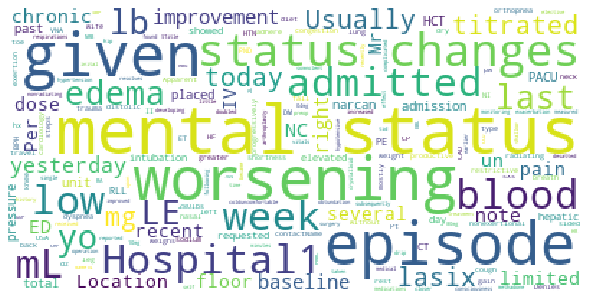

In [52]:
stopwords = set(STOPWORDS)
stopwords.update(["patient", "now", "started", "transferred", "noted","presented","family","reports","approximately","noted","home","Hospital"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [53]:
# convert dataframe into list
sentences = df['lines'].tolist()
tagged_texts = pos_tag_sents(map(word_tokenize, sentences))

In [54]:
i=0
lines = []
sent_no = []
pos_tag = []
for val in tagged_texts:
    i+=1
    for word, tag in val:
        lines.append(word)
        pos_tag.append(tag)
        sent_no.append('sentence'+str(i))
		
# create a dataframeO
data = { 'sent_no':sent_no,'words': lines, 'pos_tag':pos_tag}
ner_df = pd.DataFrame(data)
ner_df.head(10)

,sent_no,words,pos_tag
0,sentence1,65,CD
1,sentence1,yo,JJ
2,sentence1,hx,NN
3,sentence1,restrictive,JJ
4,sentence1,lung,NN
5,sentence1,dz,NN
6,sentence1,CAD,NNP
7,sentence1,distolic,JJ
8,sentence1,HF,NNP
9,sentence1,OSA,NNP


In [56]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p) for w, p in zip(s['words'].values.tolist(),
                                                       s['pos_tag'].values.tolist())]
                                                       
        self.grouped = self.df.groupby("sent_no").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['sentence{}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [57]:
#Displaying one full sentence
getter = sentence(ner_df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'65 yo hx restrictive lung dz CAD distolic HF OSA HTN BPH type II DM pw progressively worsening shortness breath LE edema'

In [64]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

sentences = getter.sentences
len(sentences)

[('Pt', 'NNP'), ('reports', 'NNS'), ('last', 'JJ'), ('1', 'CD'), ('week', 'NN'), ('worsening', 'VBG'), ('dyspnea', 'NN'), ('rest', 'NN'), ('exertion', 'NN')]


46

In [59]:
# Feature extraction
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [60]:
X = [sent2features(s) for s in sentences]

In [61]:
print(X[0])

[{'bias': 1.0, 'word.lower()': '65', 'word[-3:]': '65', 'word[-2:]': '65', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': True, 'postag': 'CD', 'postag[:2]': 'CD', 'BOS': True, '+1:word.lower()': 'yo', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'JJ', '+1:postag[:2]': 'JJ'}, {'bias': 1.0, 'word.lower()': 'yo', 'word[-3:]': 'yo', 'word[-2:]': 'yo', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'JJ', 'postag[:2]': 'JJ', '-1:word.lower()': '65', '-1:word.istitle()': False, '-1:word.isupper()': False, '-1:postag': 'CD', '-1:postag[:2]': 'CD', '+1:word.lower()': 'hx', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'NN', '+1:postag[:2]': 'NN'}, {'bias': 1.0, 'word.lower()': 'hx', 'word[-3:]': 'hx', 'word[-2:]': 'hx', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'NN', 'postag[:2]': 'NN', '-1:word.lower()': 'yo', '-1:word.istitle()': False, '-1:word

In [62]:
#Predicting on the test set.
y_pred = crf.predict(X)

In [63]:
# create a dataframeO
data = { 'X_test':X,'y_pred':y_pred}
test_df = pd.DataFrame(data)
test_df.to_csv("C:/Users/kiruthika.parthiban/Desktop/EHR/validation.csv")